In [47]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
import corner
from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import MCMC_data_file, zehavi_data_file_20, guo_data_file, mock_data, mock_data_2
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare
from noisyopt import minimizeCompass

In [2]:
wp_ng_vals = zehavi_data_file_20.get_wp()
bin_edges = zehavi_data_file_20.get_bins()
cov_matrix = zehavi_data_file_20.get_cov()
err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

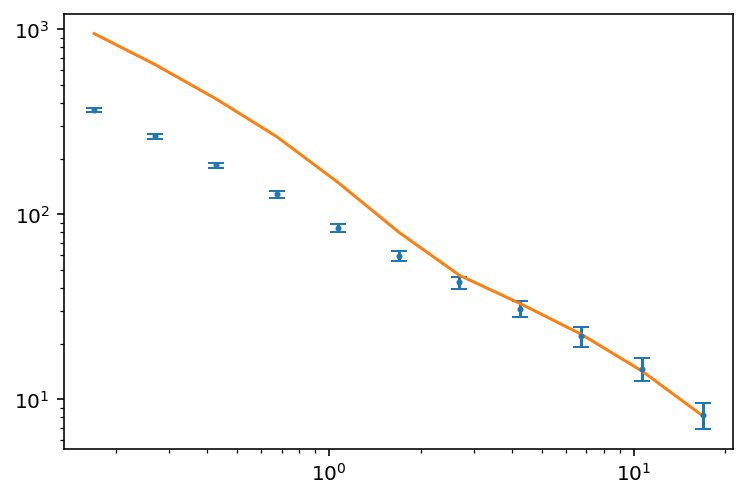

In [9]:
#cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax')
cens_occ_model = Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()

#sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax', modulate_with_cenocc=True)
sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True)
sats_prof_model = NFWPhaseSpace()

#halocat = CachedHaloCatalog(simname='bolshoi',redshift = 0.0)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

try:
    model_instance.mock.populate()
except:
    model_instance.populate_mock(halocat)
        
alpha,logM0,logM1 = [1.16,13.28-1.7,13.28]
model_instance.param_dict['alpha'] = alpha
model_instance.param_dict['logM0'] = logM0
model_instance.param_dict['logM1'] = logM1

model_instance.param_dict['logMmin'] = 12.2
model_instance.param_dict['sigma_logM'] = 0.02

model_instance.mock.populate()
    
pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'],
            model_instance.mock.galaxy_table['y'],
            model_instance.mock.galaxy_table['z'],
            period = Lbox)
x = pos[:,0]
y = pos[:,1]
z = pos[:,2]
velz = model_instance.mock.galaxy_table['vz']

pos_zdist = return_xyz_formatted_array(x,y,z,period=Lbox,
                velocity=velz,velocity_distortion_dimension='z')
pi_max = 60.
nthreads = 4
wp_calc = wp(Lbox,pi_max,nthreads,bin_edges,pos_zdist[:,0],
                     pos_zdist[:,1],pos_zdist[:,2],verbose=False)
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
plt.plot(bin_cen,wp_calc['wp'])
plt.yscale('log')
plt.xscale('log')

In [13]:
ng = model_instance.mock.number_density
print(ng,wp_ng_vals[0])

0.0040518125 0.00656


In [ ]:
def _get_ng(guess):
    model_instance.param_dict['logMmin'] = guess[0]
    model_instance.param_dict['sigma_logM'] = guess[1]
    
    model_instance.mock.populate()
    
    pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'],
            model_instance.mock.galaxy_table['y'],
            model_instance.mock.galaxy_table['z'],
            period = Lbox)
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    velz = model_instance.mock.galaxy_table['vz']

    pos_zdist = return_xyz_formatted_array(x,y,z,period=Lbox,
                velocity=velz,velocity_distortion_dimension='z')
    pi_max = 60.
    nthreads = 4
    wp_calc = wp(Lbox,pi_max,nthreads,bin_edges,pos_zdist[:,0],
                     pos_zdist[:,1],pos_zdist[:,2],verbose=False)
    wp_diff = np.mean(wp_ng_vals[1:len(wp_ng_vals)]-wp_calc['wp'])
    
    ng = model_instance.mock.number_density
    ng_diff = wp_ng_vals[0]-ng
    return ng_diff + wp_diff

In [ ]:
res = op.minimize(_get_ng,[11.96,0.38],options={'maxiter': 10,'disp':True})

In [30]:
res = minimizeCompass(_get_ng,[11.96,0.38], deltatol=0.1, paired=False)

Try having a grid of logMmin values and then do a one-param fit for sigma

In [126]:
logMmin = np.logspace(11,14,100)

In [127]:
#cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax')
cens_occ_model = Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()

#sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax', modulate_with_cenocc=True)
sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True)
sats_prof_model = NFWPhaseSpace()

#halocat = CachedHaloCatalog(simname='bolshoi',redshift = 0.0)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

try:
    model_instance.mock.populate()
except:
    model_instance.populate_mock(halocat)
        
alpha,logM0,logM1 = [1.16,13.28-1.7,13.28]
model_instance.param_dict['alpha'] = alpha
model_instance.param_dict['logM0'] = logM0
model_instance.param_dict['logM1'] = logM1

In [135]:
def _find_sigma(guess):
    model_instance.param_dict['sigma_logM'] = guess[0]
    model_instance.mock.populate()
    ng = model_instance.mock.number_density
    print(guess[0],ng)
    ng_diff = wp_ng_vals[0]-ng
    
    return ng_diff

In [147]:
sig_fits = []
func_val = []
ng
for m in logMmin:
    print(np.log10(m))
    model_instance.param_dict['logMmin'] = np.log10(m)
    res = minimizeCompass(_find_sigma,[0.3], bounds = [[0.01,2.]],deltatol=0.01, niter = 10, paired=False,disp=False,errorcontrol=False)
    sig_fits.append(res.x[0])
    func_val.append(res.fun)
    print(res.fun)

11.0
1.3 0.022742078125
0.3 0.02889109375
0.01 0.032667890625
1.01 0.0238493125
0.51 0.026868703125
0.26 0.02936196875
0.135 0.03099890625
0.0725 0.0319123125
0.04125 0.032371484375
0.02 0.03262734375
-0.026107890625
11.030303030303031
0.01 0.031910453125
0.3 0.0282086875
1.01 0.023427859375
0.51 0.02629775
0.26 0.028639953125
0.135 0.030189015625
0.0725 0.0310775625
0.04125 0.031534234375
0.02 0.031835078125
-0.025350453125000002
11.06060606060606
1.3 0.022034890625
0.3 0.02744384375
0.01 0.030108734375
1.01 0.023008328125
0.51 0.02570446875
0.26 0.027830203125
0.135 0.029209046875
0.0725 0.029870359375
0.04125 0.030104828125
0.02 0.030120984375
0.03 0.03012540625
0.04 0.03010978125
0.019999999999999997 0.03012021875
-0.02356540625
11.090909090909092
0.01 0.02842278125
0.3 0.026620890625
1.01 0.022604859375
0.51 0.025052765625
0.26 0.026959921875
0.135 0.02806146875
0.0725 0.028450359375
0.041249999999999995 0.02845221875
0.05125 0.028467609375
0.06125 0.028456
-0.021907609375
11.1212

1.5 0.013660859375
1.75 0.014071875
1.875 0.014231125
1.9375 0.0142865625
1.96875 0.014340484375
1.99 0.01435753125
-0.007800140625
11.818181818181818
0.01 0.007504671875
0.3 0.0081064375
1.3 0.012864265625
2.0 0.014134171875
1.0 0.011891703125
1.5 0.01334171875
1.75 0.013779109375
1.875 0.01396828125
1.9375 0.014038265625
1.96875 0.0140836875
1.99 0.014106375
-0.007574171875000001
11.848484848484848
0.01 0.007134015625
0.3 0.007696
1.3 0.0125169375
0.30000000000000004 0.007696
2.0 0.013884328125
1.0 0.011485203125
1.5 0.013001296875
1.75 0.01351484375
1.875 0.013687125
1.9375 0.013776671875
1.96875 0.0138248125
1.99 0.01386125
-0.007324328125
11.878787878787879
1.3 0.012173578125
0.3 0.007301375
0.30000000000000004 0.00728534375
2.0 0.0135881875
1.0 0.0110918125
1.5 0.012708125
1.75 0.01321359375
1.875 0.013408859375
1.9375 0.013527921875
1.96875 0.013573109375
1.99 0.0136125625
1.98 0.013597203125
-0.0070525625
11.90909090909091
0.01 0.0064368125
0.3 0.006947875
1.3 0.011836296875
2.

1.875 0.0069410625
1.9375 0.007154046875
1.96875 0.00724990625
1.99 0.007344265625
-0.0008275156250000006
12.757575757575758
0.01 0.00195271875
0.3 0.0020269375
1.3 0.00455578125
2.0 0.00717090625
1.0 0.003384046875
1.5 0.0053523125
1.75 0.00630625
1.875 0.00675484375
1.9375 0.00696415625
1.96875 0.0070695625
1.99 0.007144609375
-0.0006109062500000003
12.787878787878787
0.01 0.00188196875
0.3 0.001974359375
1.3 0.004381234375
0.30000000000000004 0.001967515625
2.0 0.00698890625
1.0 0.003233953125
1.5 0.005174328125
1.75 0.006136
1.875 0.006566578125
1.9375 0.006794265625
1.96875 0.006890375
1.99 0.006952578125
-0.00042890625000000047
12.818181818181818
0.01 0.001818546875
0.3 0.001899296875
1.3 0.004207015625
2.0 0.006806828125
1.0 0.003111328125
1.5 0.004992078125
1.75 0.00595690625
1.875 0.006391015625
1.9375 0.0066198125
1.96875 0.006695734375
1.99 0.006783796875
-0.0002468281250000001
12.848484848484848
0.01 0.001767
0.3 0.001831453125
1.3 0.004053390625
2.0 0.0066429375
1.0 0.0029

1.99 0.00296978125
0.0035690624999999998
13.696969696969697
0.01 0.00072015625
0.3 0.000728078125
1.3 0.001311484375
2.0 0.002897078125
1.0 0.000957296875
1.5 0.001669453125
1.75 0.002235875
1.875 0.002555765625
1.9375 0.002726953125
1.96875 0.002812796875
1.99 0.002875875
0.003662921875
13.727272727272727
0.01 0.000696015625
0.3 0.0007040625
1.3 0.00125140625
0.30000000000000004 0.000699046875
2.0 0.002804796875
1.0 0.000918
1.5 0.001599078125
1.75 0.002153375
1.875 0.002470265625
1.9375 0.00264578125
1.96875 0.002723296875
1.99 0.002772734375
0.003755203125
13.757575757575758
1.3 0.001197203125
0.3 0.0006719375
0.30000000000000004 0.0006773125
2.0 0.002701625
1.0 0.000887515625
1.5 0.001536703125
1.75 0.002079453125
1.875 0.00238328125
1.9375 0.002546328125
1.96875 0.002637265625
1.99 0.0026885
0.003858375
13.787878787878789
1.3 0.00114903125
0.3 0.00065025
0.30000000000000004 0.000649234375
2.0 0.00263575
1.0 0.000854640625
1.5 0.00147584375
1.75 0.00199890625
1.875 0.002304046875
1

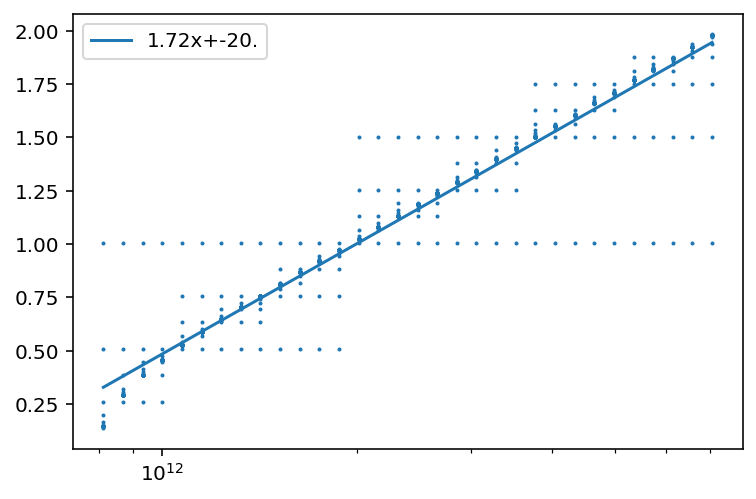

In [330]:
f = np.load('logMmin_sigma.npy',allow_pickle=True)
cond1 = f[1]<2.
cond2 = f[1][cond1]>0.01
plt.scatter(f[0][cond1][cond2],f[1][cond1][cond2],s=1)
#plt.hist(f[0][cond1][cond2],histtype='step',bins=20)
#plt.hist(f[1][cond1][cond2],histtype='step')
m, b = np.polyfit(np.log10(f[0])[cond1][cond2], f[1][cond1][cond2], 1)
plt.plot(f[0][cond1][cond2],m*np.log10(f[0])[cond1][cond2]+b,label=str(m)[0:4]+'x+'+str(b)[0:4])
plt.legend()
plt.xscale('log')
plt.show()

In [331]:
1.7*12.-20

0.3999999999999986

0.009925609375
11.03
0.0101045
11.059999999999999
0.01031625
11.089999999999998
0.0105125
11.119999999999997
0.010755765625
11.149999999999997
0.0109964375
11.179999999999996
0.011285875
11.209999999999996
0.011605625
11.239999999999995
0.011966078125
11.269999999999994
0.01235834375
11.299999999999994
0.01280796875
11.329999999999993
0.01330834375
11.359999999999992
0.013857953125
11.389999999999992
0.01449290625
11.419999999999991
0.01520328125
11.44999999999999
0.016017890625
11.47999999999999
0.0169125625
11.50999999999999
0.0178765
11.539999999999988
0.018896078125
11.569999999999988
0.0199115
11.599999999999987
0.020892453125
11.629999999999987
0.021752671875
11.659999999999986
0.022500765625
11.689999999999985
0.023155828125
11.719999999999985
0.0237274375
11.749999999999984
0.024218390625
11.779999999999983
0.00802375
11.809999999999983
0.007642546875
11.839999999999982
0.00734175
11.869999999999981
0.00706315625
11.89999999999998
0.006826265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.430 secs


11.92999999999998
0.00663209375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.324 secs


11.95999999999998
0.0064774375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.114 secs


11.989999999999979
0.006340921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.048 secs


12.019999999999978
0.006238328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.969 secs


12.049999999999978
0.00616478125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.887 secs


12.079999999999977
0.0060925625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.795 secs


12.109999999999976
0.00606271875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.774 secs


12.139999999999976
0.006033609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.770 secs


12.169999999999975
0.006009515625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.737 secs


12.199999999999974
0.00600215625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.736 secs


12.229999999999974
0.0059989375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.828 secs


12.259999999999973
0.005995078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.751 secs


12.289999999999973
0.005993140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.783 secs


12.319999999999972
0.006007578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.756 secs


12.349999999999971
0.005987328125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.827 secs


12.37999999999997
0.00600178125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.823 secs


12.40999999999997
0.00602115625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.795 secs


12.43999999999997
0.00601025


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.765 secs


12.469999999999969
0.00602053125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.767 secs


12.499999999999968
0.00603303125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.787 secs


12.529999999999967
0.006033984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.783 secs


12.559999999999967
0.006025453125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.796 secs


12.589999999999966
0.006040375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.800 secs


12.619999999999965
0.006055265625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.837 secs


12.649999999999965
0.006064140625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.834 secs


12.679999999999964
0.0060728125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.840 secs


12.709999999999964
0.006076578125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.849 secs


12.739999999999963
0.00607271875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.826 secs


12.769999999999962
0.006090390625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.850 secs


12.799999999999962
0.006090953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.907 secs


12.829999999999961
0.006091421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.914 secs


12.85999999999996
0.006103609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.088 secs


12.88999999999996
0.00610775


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.061 secs


12.919999999999959
0.006127546875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.940 secs


12.949999999999958
0.006110765625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.851 secs


12.979999999999958
0.006116203125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.844 secs


13.009999999999957
0.006132953125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.832 secs


13.039999999999957
0.006132296875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.855 secs


13.069999999999956
0.00612928125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.831 secs


13.099999999999955
0.006141828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.887 secs


13.129999999999955
0.00615909375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.876 secs


13.159999999999954
0.006147078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.873 secs


13.189999999999953
0.006156484375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.890 secs


13.219999999999953
0.006163078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.887 secs


13.249999999999952
0.006173890625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.933 secs


13.279999999999951
0.006170109375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.979 secs


13.30999999999995
0.00615525


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.918 secs


13.33999999999995
0.006180609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.932 secs


13.36999999999995
0.006166796875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.972 secs


13.399999999999949
0.00618309375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.985 secs


13.429999999999948
0.006189984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.997 secs


13.459999999999948
0.006211359375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.972 secs


13.489999999999947
0.006186609375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.941 secs


13.519999999999946
0.006189828125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.939 secs


13.549999999999946
0.0062015625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.949 secs


13.579999999999945
0.0062156875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.974 secs


13.609999999999944
0.00620940625


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.055 secs


13.639999999999944
0.006221921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.060 secs


13.669999999999943
0.00621196875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.027 secs


13.699999999999942
0.006208421875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.987 secs


13.729999999999942
0.006210984375


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.991 secs


13.759999999999941
0.00622425


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.040 secs


13.78999999999994
0.006221921875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.035 secs


13.81999999999994
0.006238078125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.995 secs


13.84999999999994
0.00622471875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.995 secs


13.879999999999939
0.0062208125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.969 secs


13.909999999999938
0.00623075


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.996 secs


13.939999999999937
0.006239125


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.974 secs


13.969999999999937
0.0062271875


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.970 secs


13.999999999999936


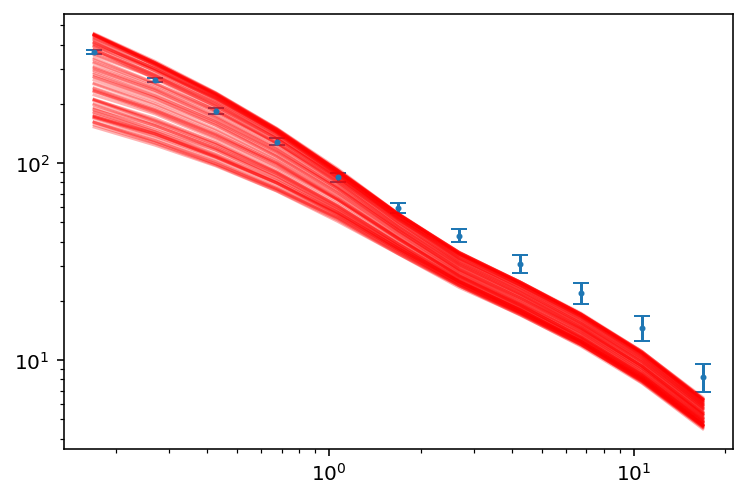

In [341]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
best_fits = []
Mmin = 11.
for i in range(100):
    sigma = 1.7*Mmin-20. 
    model_instance.param_dict['logMmin'] = Mmin
    model_instance.param_dict['sigma_logM'] = sigma

    try:
        model_instance.mock.populate()
    except:
        model_instance.populate_mock(halocat)
        
    halo_table = model_instance.mock.halo_table
    pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'], model_instance.mock.galaxy_table['y'],
                                 model_instance.mock.galaxy_table['z'],period = Lbox)
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    velz = model_instance.mock.galaxy_table['vz']
    pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, velocity=velz, velocity_distortion_dimension='z')
    print(model_instance.mock.number_density)
    if model_instance.mock.number_density < 0.007:
        best_fits.append([Mmin,sigma])
        wp_calc = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],
                    verbose=True)#,xbin_refine_factor=1, ybin_refine_factor=2, zbin_refine_factor=1)
        plt.plot(bin_cen,wp_calc['wp'],markersize=2,label=str(Mmin)[0:3]+''+str(sigma)[0:3],c='r',alpha=0.3)
    
    plt.xscale('log')
    plt.yscale('log')
    Mmin+=0.03
    print(Mmin)